In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.ticker import FuncFormatter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed


Data quality check and insights

In [68]:
# Load data
data = pd.read_csv('Half_Ironman_df6.csv')

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840075 entries, 0 to 840074
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Gender           840075 non-null  object
 1   AgeGroup         840075 non-null  object
 2   AgeBand          840075 non-null  int64 
 3   Country          840075 non-null  object
 4   CountryISO2      840075 non-null  object
 5   EventYear        840075 non-null  int64 
 6   EventLocation    840075 non-null  object
 7   SwimTime         840075 non-null  int64 
 8   Transition1Time  840075 non-null  int64 
 9   BikeTime         840075 non-null  int64 
 10  Transition2Time  840075 non-null  int64 
 11  RunTime          840075 non-null  int64 
 12  FinishTime       840075 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 83.3+ MB


In [70]:
data.describe(include='all')

,Gender,AgeGroup,AgeBand,Country,CountryISO2,EventYear,EventLocation,SwimTime,Transition1Time,BikeTime,Transition2Time,RunTime,FinishTime
count,840075,840075,840075.00,840075,840075,840075.00,840075,840075.00,840075.00,840075.00,840075.00,840075.00,840075.00
unique,2,15,NaN,240,240,NaN,195,NaN,NaN,NaN,NaN,NaN,NaN
top,M,35-39,NaN,United States,US,NaN,IRONMAN 70.3 World Championship,NaN,NaN,NaN,NaN,NaN,NaN
freq,635680,160918,NaN,332037,332037,NaN,26123,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,36.90,NaN,NaN,2015.11,NaN,2340.25,286.68,10675.31,219.79,7606.97,21129.01
std,NaN,NaN,10.84,NaN,NaN,3.18,NaN,486.45,98.42,1397.95,94.24,1588.10,3076.23
min,NaN,NaN,0.00,NaN,NaN,2004.00,NaN,1201.00,46.00,6511.00,46.00,4002.00,13004.00
25%,NaN,NaN,30.00,NaN,NaN,2013.00,NaN,2010.00,211.00,9682.00,147.00,6440.00,18919.00
50%,NaN,NaN,35.00,NaN,NaN,2016.00,NaN,2286.00,280.00,10503.00,205.00,7362.00,20839.00
75%,NaN,NaN,45.00,NaN,NaN,2018.00,NaN,2604.00,359.00,11483.00,279.00,8544.00,23052.00


In [71]:
data['Gender'].value_counts()

Gender
M    635680
F    204395
Name: count, dtype: int64

In [72]:
data.isna().sum()

Gender             0
AgeGroup           0
AgeBand            0
Country            0
CountryISO2        0
EventYear          0
EventLocation      0
SwimTime           0
Transition1Time    0
BikeTime           0
Transition2Time    0
RunTime            0
FinishTime         0
dtype: int64

In [73]:
df = data.dropna()

In [74]:

df = df.query('2010 <= EventYear <= 2020')


In [75]:
# Charts inline
%matplotlib inline


# Define graphics style
plt.style.use('seaborn-whitegrid')

# Set precision to two decimals
pd.set_option("display.precision", 2)

# Male and female colors
mcol = 'royalblue'
fcol = 'orchid'

<ipython-input-75-a63814dee7b9>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [76]:
# Function to convert time in seconds to HH:MM:SS
def time_in_HHMMSS(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f'{hours:02}:{minutes:02}:{secs:02}'

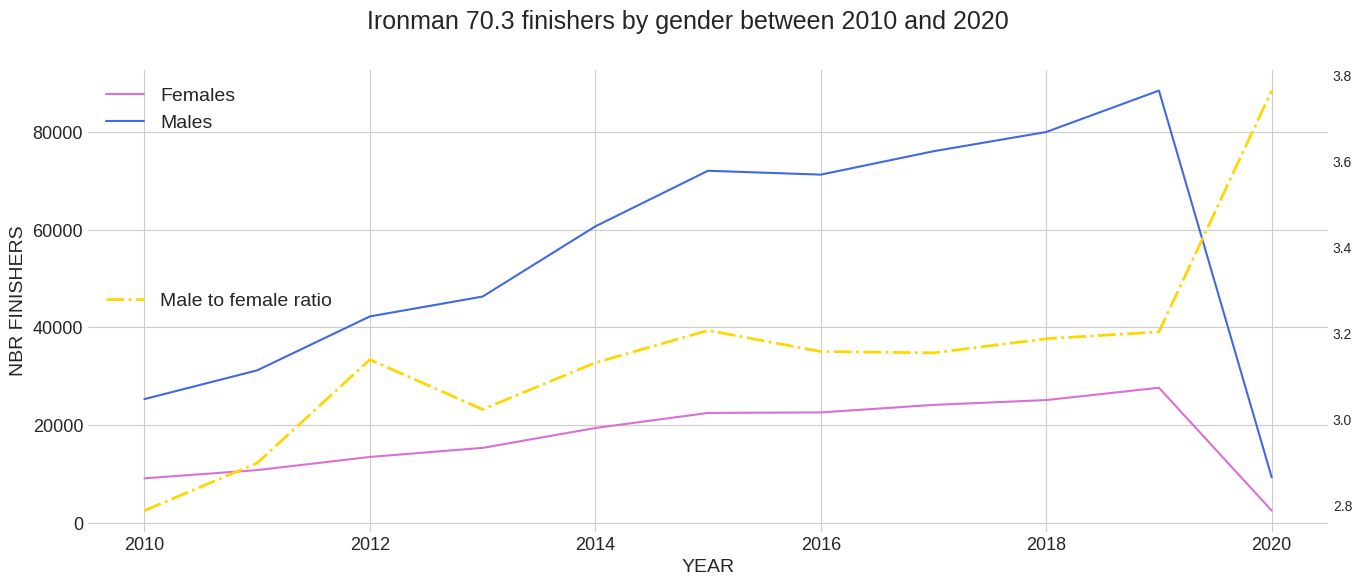

In [77]:
# Evolution of the number of finishers by gender
female_finishers_by_year = df[df['Gender']=='F'].groupby(by=['EventYear']).count()
male_finishers_by_year = df[df['Gender']=='M'].groupby(by=['EventYear']).count()

f, ax = plt.subplots(1,1, figsize=(16,6))
f.suptitle("Ironman 70.3 finishers by gender between 2010 and 2020", fontsize=18)

ax.plot(female_finishers_by_year.index, female_finishers_by_year['Gender'],
        label='Females', lw=1.5, color=fcol)
ax.plot(male_finishers_by_year.index, male_finishers_by_year['Gender'],
        label='Males', lw=1.5, color=mcol)

ax.set_xlabel('YEAR', fontsize='14')
ax.set_ylabel('NBR FINISHERS', fontsize='14')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='upper left', fontsize='14')
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax2 = ax.twinx()
ax2.plot(male_finishers_by_year.index, male_finishers_by_year['Gender']/female_finishers_by_year['Gender'],
         label='Male to female ratio', lw=2, color='gold', linestyle='-.')
ax2.legend(loc='center left', fontsize=14)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.grid(visible=False)
plt.show()

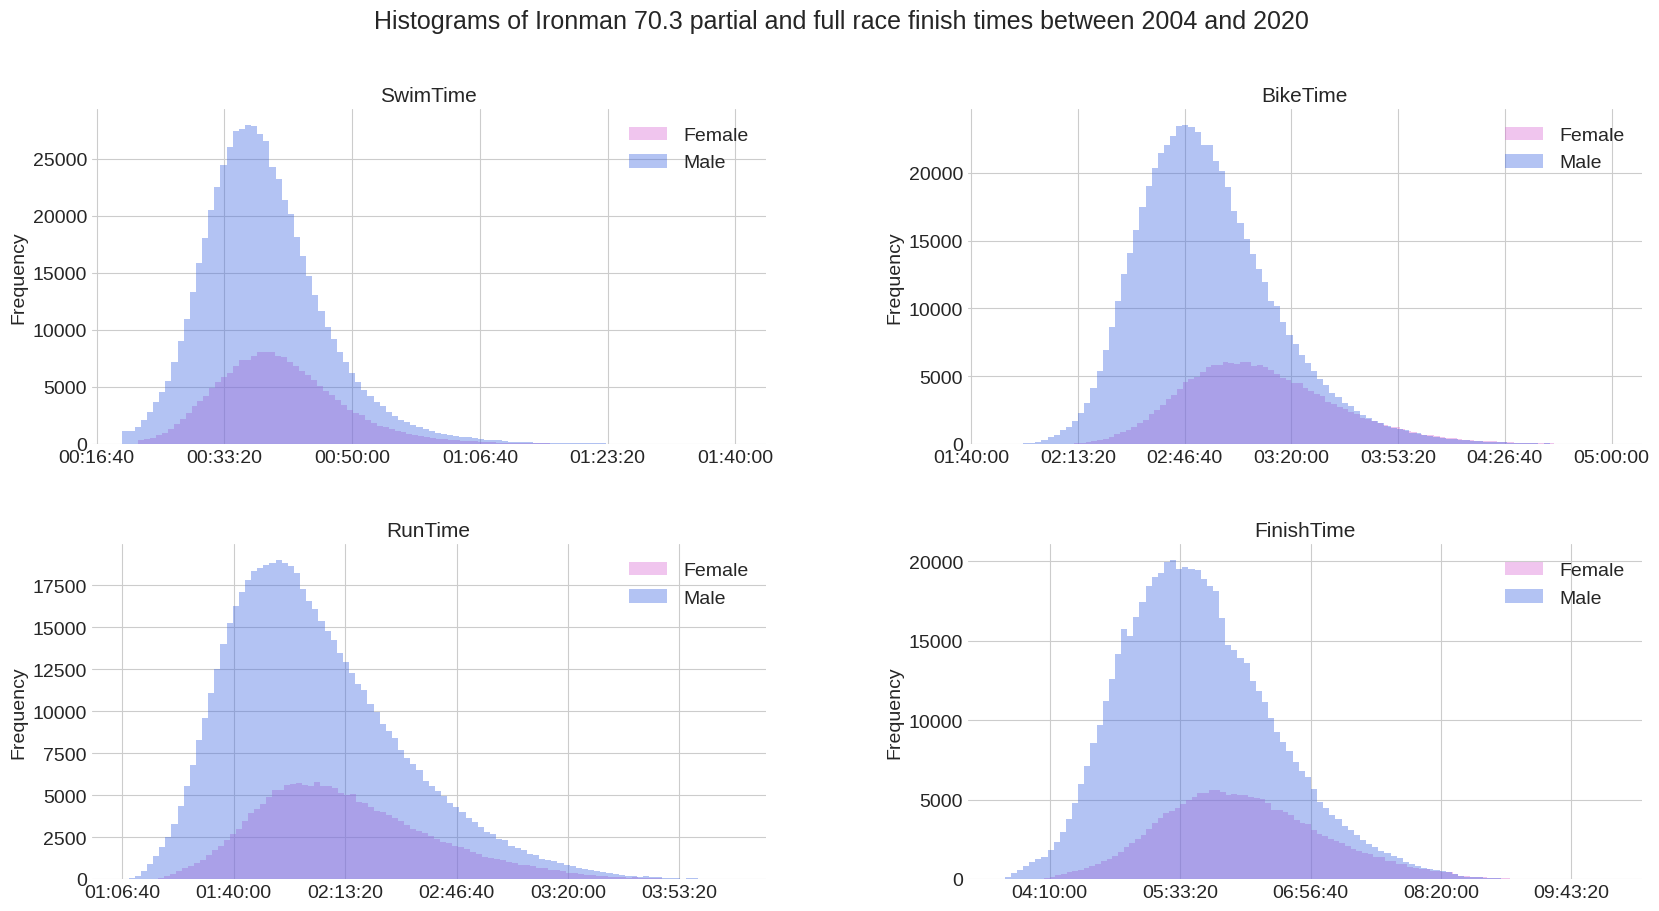

In [78]:
# List of time columns
timeColumns = ['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']


# Make sur the time columns are numerical
for col in timeColumns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert time columns in HH:MM:SS format
for col in timeColumns:
    df[col + '_HHMMSS'] = df[col].apply(time_in_HHMMSS)

# Code for the plot


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle("Histograms of Ironman 70.3 partial and full race finish times between 2004 and 2020", fontsize=18)

i, j = 0, 0
for x in timeColumns:
    # Histograms for each gender
    df[df['Gender'] == 'F'].hist(column=x, bins=100, label='Female', color=fcol, alpha=0.4, ax=ax[i, j])
    df[df['Gender'] == 'M'].hist(column=x, bins=100, label='Male', color=mcol, alpha=0.4, ax=ax[i, j])

    ax[i, j].set_title(x, fontsize=15)
    ax[i, j].set_ylabel('Frequency', fontsize=14)
    ax[i, j].tick_params(axis='both', which='major', labelsize=14)

    # Format xtick labels in HH:MM:SS
    formatter = FuncFormatter(lambda s, _: time_in_HHMMSS(int(s)))
    ax[i, j].xaxis.set_major_formatter(formatter)

    ax[i, j].legend(loc='upper right', fontsize=14)

    # Hide corners of the plot
    ax[i, j].spines["left"].set_visible(False)
    ax[i, j].spines["right"].set_visible(False)
    ax[i, j].spines["top"].set_visible(False)
    ax[i, j].spines["bottom"].set_visible(False)

    if j < 1:
        j += 1
    else:
        j = 0
        i += 1

plt.show()

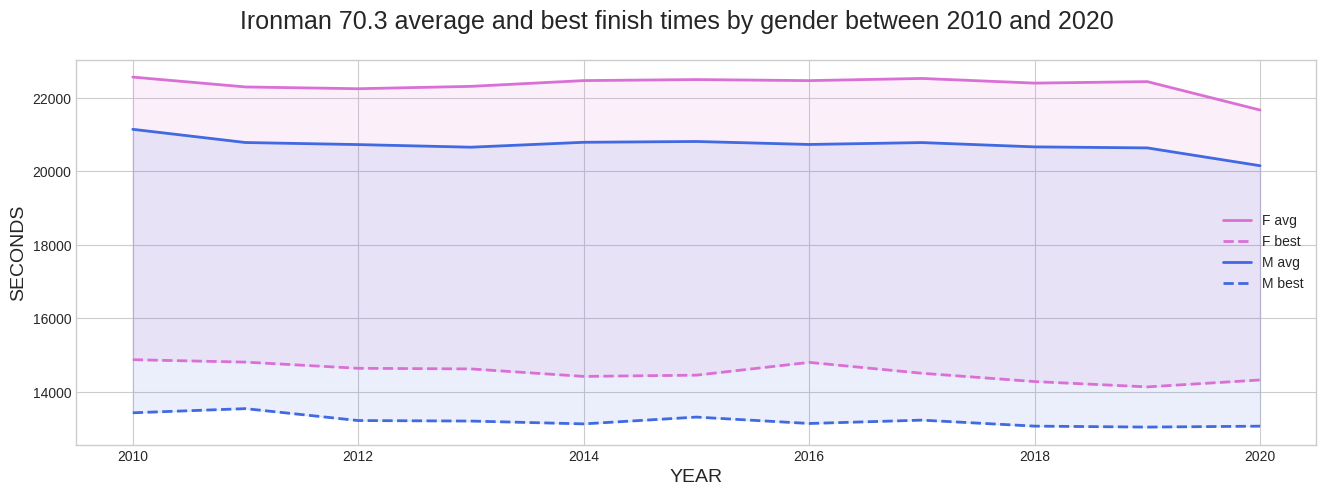

In [79]:

# Calculate male and female average and best (min) finish time
female_average_time_by_year = df[df['Gender']=='F'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).mean()
female_best_time_by_year = df[df['Gender']=='F'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).min()
male_average_time_by_year = df[df['Gender']=='M'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).mean()
male_best_time_by_year = df[df['Gender']=='M'][['EventYear', 'FinishTime']].groupby(by=['EventYear']).min()

# Code for the plot and the axes
f, ax = plt.subplots(1, 1, figsize=(16, 5))
f.suptitle("Ironman 70.3 average and best finish times by gender between 2010 and 2020", fontsize=18)

# Lines for women
ax.plot(female_average_time_by_year.index, female_average_time_by_year['FinishTime'],
        label='F avg', lw=2, color=fcol)
ax.plot(female_best_time_by_year.index, female_best_time_by_year['FinishTime'],
        label='F best', lw=2, color=fcol, linestyle='--')
ax.fill_between(female_average_time_by_year.index, female_best_time_by_year['FinishTime'], female_average_time_by_year['FinishTime'],
               color=fcol, alpha=0.1)

# Lines for men
ax.plot(male_average_time_by_year.index, male_average_time_by_year['FinishTime'],
        label='M avg', lw=2, color=mcol)
ax.plot(male_best_time_by_year.index, male_best_time_by_year['FinishTime'],
        label='M best', lw=2, color=mcol, linestyle='--')
ax.fill_between(male_average_time_by_year.index, male_best_time_by_year['FinishTime'], male_average_time_by_year['FinishTime'],
               color=mcol, alpha=0.1)

# Labels
ax.set_xlabel('YEAR', fontsize=14)
ax.set_ylabel('SECONDS', fontsize=14)

# Legend
ax.legend()

# Show the plot
plt.show()


In [80]:
# Male stats
df_m_HMS = df[df['Gender']=='M'][['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']].aggregate(['mean', 'std', 'min', 'max'])

for x in timeColumns:
  df_m_HMS[x] = df_m_HMS[x].apply(time_in_HHMMSS)

df_m_HMS.columns = pd.MultiIndex.from_product([["Male stats"], df_m_HMS.columns])

# Female stats
df_f_HMS = df[df['Gender']=='F'][['SwimTime', 'BikeTime', 'RunTime', 'FinishTime']].aggregate(['mean', 'std', 'min', 'max'])

for x in timeColumns:
  df_f_HMS[x] = df_f_HMS[x].apply(time_in_HHMMSS)

df_f_HMS.columns = pd.MultiIndex.from_product([["Female stats"], df_f_HMS.columns])



df_mf_HMS = pd.concat([df_m_HMS, df_f_HMS], axis=1)
df_mf_HMS

Male stats                               \
                         SwimTime                     BikeTime   
mean  0.0:38.0:31.881143383742256  2.0:53.0:59.248533145930196   
std     0.0:7.0:59.36374078664494   0.0:21.0:42.05654775268954   
min                  0.0:20.0:1.0                1.0:48.0:31.0   
max                 1.0:39.0:57.0                4.0:59.0:53.0   

                                                               \
                          RunTime                  FinishTime   
mean   2.0:4.0:34.882577088567814  5.0:45.0:31.47535850908025   
std   0.0:26.0:12.189963803612955  0.0:49.0:20.38356477650541   
min                  1.0:6.0:42.0               3.0:37.0:15.0   
max                  4.0:9.0:59.0               10.0:8.0:49.0   

                    Female stats                               \
                        SwimTime                     BikeTime   
mean  0.0:40.0:35.57819779671854   3.0:10.0:33.78531249513071   
std   0.0:8.0:17.752818671600437  0.0:23.0:47.159118131446576   
min                 0.0:22.0:1.0                 2.0:1.0:30.0   
max                1.0:39.0:56.0                4.0:59.0:47.0   

                                                               
                         RunTime                   FinishTime  
mean  2.0:13.0:48.23312090001127   6.0:13.0:38.88500553157792  
std   0.0:26.0:7.055444190857315  0.0:51.0:24.923590534295727  
min                1.0:10.0:15.0                3.0:55.0:29.0  
max                 4.0:9.0:43.0                9.0:58.0:19.0

<ipython-input-81-33a76c5d082a>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(l0, fontsize=13)


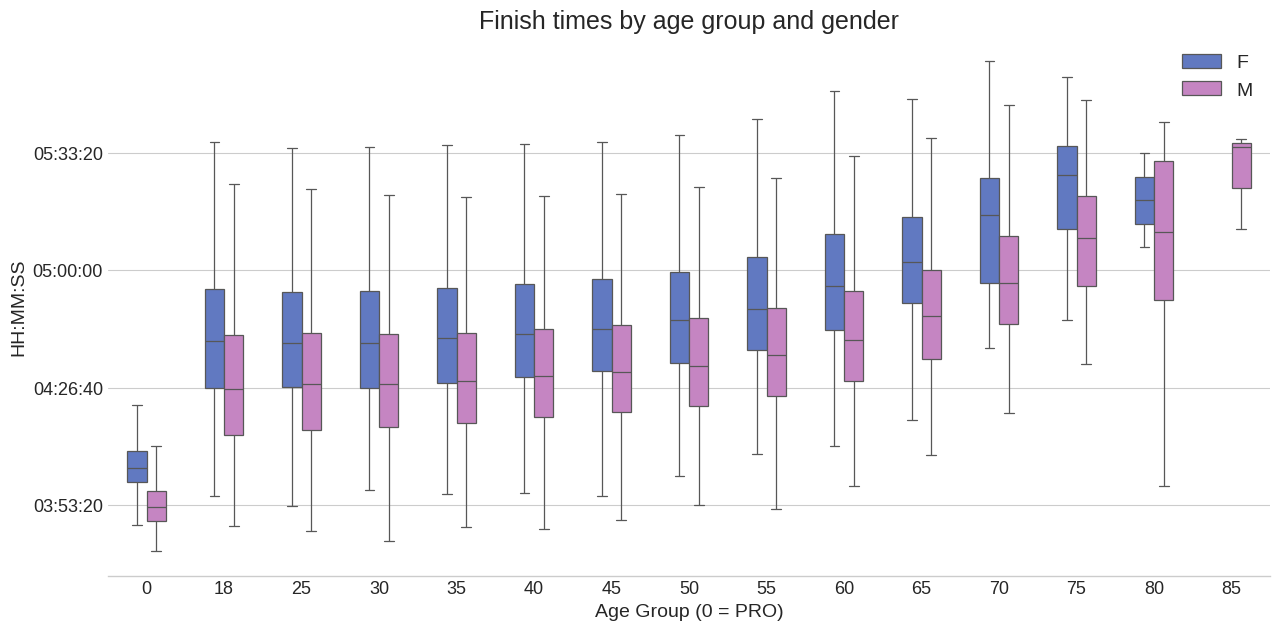

In [81]:
# Get x-axis ticks in seconds and convert to HH:MM:SS
l0 = []
for t in ax.get_yticklabels():
  l0.append(time_in_HHMMSS(int(t.get_text())))

# Distribution of overall finish times (in HH:MM:SS) by age group and gender
fig, ax = plt.subplots(figsize=(15,7))

ax.set_title("Finish times by age group and gender", fontsize=18);
sns.boxplot(x = "AgeBand", y = "FinishTime", hue='Gender', data=df, saturation=0.6, palette=[mcol, fcol],
            width=0.5, linewidth=0.9, showfliers=False, ax=ax)
ax.set_xlabel('Age Group (0 = PRO)', fontsize=14)
ax.set_ylabel('HH:MM:SS', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_yticklabels(l0, fontsize=13)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(fontsize=14)
plt.show()

In [82]:
# Perform two-way ANOVA
model = ols('FinishTime ~ C(AgeBand) + C(Gender) + C(AgeBand):C(Gender)', data=df).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1.64e+12,1.0,202816.50,0.00e+00
C(AgeBand),2.43e+11,14.0,2146.57,0.00e+00
C(Gender),9.42e+09,1.0,1164.87,4.02e-255
C(AgeBand):C(Gender),1.84e+09,14.0,16.22,1.58e-40
Residual,6.44e+12,795834.0,NaN,NaN


In [ ]:
#The results of the ANOVA two-way test show that, for each independent variable (age group and gender) and
#their combined effect, the calculated p-pvalues PR(>F) are zero or nearly zero, and hence we can conclude that
#the differences between age groups and genders are statistically significant.

Machine Learning (regression) : predict IRONMAN 70.3 finnish time with : Age, Sex, and Half-marathon time with marathon pace.

In [83]:


# Feature and target selection
X = df[['RunTime', 'AgeBand', 'Gender']]
y = df['FinishTime']


# Drop lines with missing values
X = X.dropna()
y = y[X.index]

# Gender encoding
X['Gender'] = X['Gender'].map({'M': 0, 'F': 1})

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['RunTime', 'AgeBand']),
        ('cat', OneHotEncoder(), ['Gender'])
    ])



In [84]:
# Models to use
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42),  # Nombre d'estimations réduit
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),  # Nombre d'estimations réduit
    'XGBoost': XGBRegressor(n_estimators=50, random_state=42)  # Nombre d'estimations réduit
}

# Function to evaluate the models
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    # Cross validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = (-cv_scores)**0.5
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return {
        'Model Name': model_name,
        'CV RMSE': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test MAE': mae,
        'Test RMSE': rmse,
        'Pipeline': pipeline
    }




In [85]:
# Evaluation of each model
results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(name, model, X_train, y_train, X_test, y_test)
    for name, model in models.items()
)

# Print results
for result in results:
    print(f"Model: {result['Model Name']}")
    print(f"Validation RMSE: {result['CV RMSE']:.2f} ± {result['CV RMSE Std']:.2f}")
    print(f"Test MAE: {result['Test MAE']:.2f}")
    print(f"Test RMSE: {result['Test RMSE']:.2f}")
    print()

Model: Linear Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Ridge Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Lasso Regression
Validation RMSE: 1288.08 ± 2.46
Test MAE: 1001.95
Test RMSE: 1293.83

Model: Random Forest
Validation RMSE: 1383.32 ± 1.58
Test MAE: 1050.20
Test RMSE: 1364.94

Model: Gradient Boosting
Validation RMSE: 1261.01 ± 1.62
Test MAE: 978.84
Test RMSE: 1267.08

Model: XGBoost
Validation RMSE: 1259.10 ± 1.79
Test MAE: 976.72
Test RMSE: 1265.22



In [86]:

# Print the best model
best_model = min(results, key=lambda x: x['Test RMSE'])
print(f"Best Model: {best_model['Model Name']}")

Best Model: XGBoost


In [93]:
# Function to convert pace (min/km) to time in seconds and HH:MM:SS
def convert_pace_to_total_time(pace_min_per_km):
    """
    Convertit une allure (min/km) en temps total pour un semi-marathon (21,1 km)

    Args:
    pace_min_per_km (float): Allure en minutes par kilomètre

    Returns:
    tuple: Temps total en secondes et formaté en HH:MM:SS
    """
    # Distance on half-marathon
    half_marathon_distance = 21.1

    # Calcul du temps total en minutes
    total_time_minutes = pace_min_per_km * half_marathon_distance

    # Convertir le temps total en secondes
    total_time_seconds = total_time_minutes * 60

    # Convertir les secondes en HH:MM:SS
    hours = int(total_time_seconds // 3600)
    minutes = int((total_time_seconds % 3600) // 60)
    seconds = int(total_time_seconds % 60)

    # Format HH:MM:SS
    total_time_hhmmss = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    return total_time_seconds, total_time_hhmmss

# Example with an average pace of 5.09 min/km at a marathon
pace_min_per_km = 5.09
total_seconds, total_hhmmss = convert_pace_to_total_time(pace_min_per_km)
print(f"Total time in secondes: {total_seconds}")
print(f"Total time in HH:MM:SS: {total_hhmmss}")

Total time in secondes: 6443.9400000000005
Total time in HH:MM:SS: 01:47:23


In [94]:
# Prediction with the best model
RunTime = total_seconds  # Exemple : time
AgeBand = 27  # Exemple : votre âge
Gender = 0  # Exemple : 0 pour homme, 1 pour femme
data_input = pd.DataFrame([[RunTime, AgeBand, Gender]], columns=['RunTime', 'AgeBand', 'Gender'])

In [104]:
predicted_time = best_model['Pipeline'].predict(data_input) #the time is in seconds
print(f'Your predicted time is : {(time_in_HHMMSS(int(predicted_time[0])))}') #time in HH:MM:SS


Your predicted time is : 05:18:01


Webscraping IRONMAN 70.3 host countries from https://www.ironman.com/im703-races

In [123]:
import requests
from bs4 import BeautifulSoup

# Send a GET request to the URL
url = "https://www.ironman.com/im703-races"
response = requests.get(url)



html_content ='''
<ul class="regionOptions"><ul key="0" data-value="Africa" class="africa"><li key="africa" data-value="Africa" class="continentTitle">Africa</li><li key="0" data-value="Egypt">Egypt</li><li key="1" data-value="Morocco">Morocco</li><li key="2" data-value="Rwanda">Rwanda</li><li key="3" data-value="South Africa">South Africa</li></ul><ul key="1" data-value="Asia" class="asia"><li key="asia" data-value="Asia" class="continentTitle">Asia</li><li key="0" data-value="Bahrain">Bahrain</li><li key="1" data-value="Dubai">Dubai</li><li key="2" data-value="India">India</li><li key="3" data-value="Israel">Israel</li><li key="4" data-value="Japan">Japan</li><li key="5" data-value="Kazakhstan">Kazakhstan</li><li key="6" data-value="Korea">Korea</li><li key="7" data-value="Malaysia">Malaysia</li><li key="8" data-value="Oman">Oman</li><li key="9" data-value="Philippines">Philippines</li><li key="10" data-value="Taiwan">Taiwan</li><li key="11" data-value="Thailand">Thailand</li><li key="12" data-value="Viet Nam">Viet Nam</li></ul><ul key="2" data-value="Europe" class="europe"><li key="europe" data-value="Europe" class="continentTitle">Europe</li><li key="0" data-value="Austria">Austria</li><li key="1" data-value="Belgium">Belgium</li><li key="2" data-value="Croatia">Croatia</li><li key="3" data-value="Czech Republic">Czech Republic</li><li key="4" data-value="Denmark">Denmark</li><li key="5" data-value="Estonia">Estonia</li><li key="6" data-value="Finland">Finland</li><li key="7" data-value="France">France</li><li key="8" data-value="Germany">Germany</li><li key="9" data-value="Greece">Greece</li><li key="10" data-value="Ireland">Ireland</li><li key="11" data-value="Italy">Italy</li><li key="12" data-value="Luxembourg">Luxembourg</li><li key="13" data-value="Netherlands">Netherlands</li><li key="14" data-value="Poland">Poland</li><li key="15" data-value="Portugal">Portugal</li><li key="16" data-value="Serbia">Serbia</li><li key="17" data-value="Spain">Spain</li><li key="18" data-value="Sweden">Sweden</li><li key="19" data-value="Switzerland">Switzerland</li><li key="20" data-value="Türkiye">Türkiye</li><li key="21" data-value="United Kingdom">United Kingdom</li></ul><ul key="3" data-value="North America" class="northamerica"><li key="north america" data-value="North America" class="continentTitle">North America</li><li key="0" data-value="Canada">Canada</li><li key="1" data-value="Mexico">Mexico</li><li key="2" data-value="Panama">Panama</li><li key="3" data-value="Puerto Rico">Puerto Rico</li><li key="4" data-value="United States">United States</li></ul><ul key="4" data-value="Oceania" class="oceania"><li key="oceania" data-value="Oceania" class="continentTitle">Oceania</li><li key="0" data-value="Australia">Australia</li><li key="1" data-value="New Zealand">New Zealand</li></ul><ul key="5" data-value="South America" class="southamerica"><li key="south america" data-value="South America" class="continentTitle">South America</li><li key="0" data-value="Argentina">Argentina</li><li key="1" data-value="Brazil">Brazil</li><li key="2" data-value="Chile">Chile</li><li key="3" data-value="Colombia">Colombia</li><li key="4" data-value="Dominican Republic">Dominican Republic</li><li key="5" data-value="Ecuador">Ecuador</li><li key="6" data-value="Perú">Perú</li><li key="7" data-value="Uruguay">Uruguay</li></ul></ul>
'''



# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Find all <ul> elements with class "regionOptions"
region_options = soup.find_all('ul', class_='regionOptions')

# Extract country names
country_names = []
for region in region_options:
    countries = region.find_all('li', class_=lambda x: x != 'continentTitle')
    for country in countries:
        if country.get('data-value'):
            country_names.append(country.get('data-value'))

print(country_names)



['Egypt', 'Morocco', 'Rwanda', 'South Africa', 'Bahrain', 'Dubai', 'India', 'Israel', 'Japan', 'Kazakhstan', 'Korea', 'Malaysia', 'Oman', 'Philippines', 'Taiwan', 'Thailand', 'Viet Nam', 'Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Poland', 'Portugal', 'Serbia', 'Spain', 'Sweden', 'Switzerland', 'Türkiye', 'United Kingdom', 'Canada', 'Mexico', 'Panama', 'Puerto Rico', 'United States', 'Australia', 'New Zealand', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Dominican Republic', 'Ecuador', 'Perú', 'Uruguay']


In [122]:
countries_list =[country_names]

<ipython-input-144-e25f999c2700>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


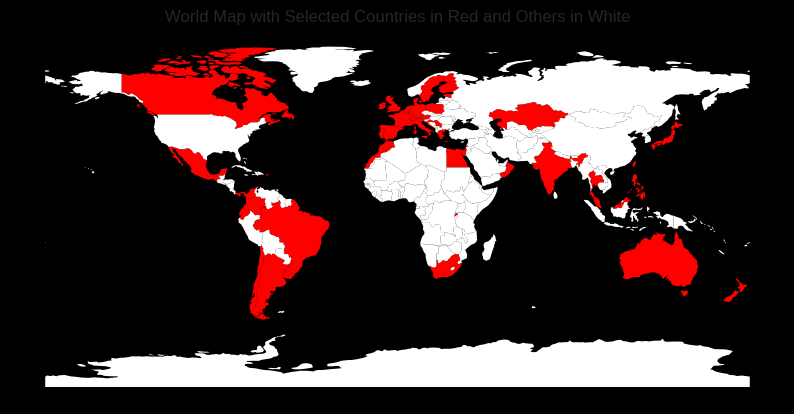

In [144]:
import geopandas as gpd

# Load country data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a mask for countries in the list
mask = world['name'].isin(countries_list)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Change the background color of the figure to black
fig.patch.set_facecolor('black')

# Display the world map with a black background
world.plot(ax=ax, color='black', edgecolor='black')

# Color the countries in the list in red
world[mask].plot(ax=ax, color='red')

# Color the countries not in the list in white
world[~mask].plot(ax=ax, color='white')

# Turn off the axis
ax.axis('off')

# Show the map
plt.title('World Map with Selected Countries in Red and Others in White')
plt.show()
